# TP53 benchmarking with training cohort data

#### TP53 experimental assay from Giacomelli AO, Yang X, Lintner RE, McFarland JM, Duby M, Kim J, et al. Mutational processes shape the landscape of TP53 mutations in human cancer. Nat Genet 2018;50:1381–7.

#### TP53 experimental assay from Kato S, Han S-Y, Liu W, Otsuka K, Shibata H, Kanamaru R, et al. Understanding the function-structure and function-mutation relationships of p53 tumor suppressor protein by high-resolution missense mutation analysis. Proc Natl Acad Sci U S A 2003;100:8424–9.

### 1. Upload data
### 2. Generate crossvalidation data
### 3. Precision recall curves
### 4. F50 score and performance

# 1. Upload data

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
from scipy.stats import fisher_exact
import copy
import gzip
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)
import matplotlib.pyplot as plt
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [2]:
TP53_Kato = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Kato.txt', sep='\t')
TP53_Kato

,chr,pos,alt,aachange,boostDM_score_MM,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,gene,boostDM_score_LY,boostDM_score_UCEC,boostDM_score_NHLY,boostDM_score_PIA,boostDM_score_CLL,boostDM_score_ST,boostDM_score_UCS,boostDM_score_PAAD,boostDM_score_OS,boostDM_score_LUAD,boostDM_score_BLCA,boostDM_score_GBM,boostDM_score_CH,boostDM_score_AML,boostDM_score_OV,boostDM_score_HGG,boostDM_score_COREAD,boostDM_score_SCLC,boostDM_score_ESCA,boostDM_score_HC,boostDM_score_LGG,boostDM_score_LUSC,boostDM_score_S,boostDM_score_PRAD,boostDM_score_LEIS,boostDM_score_HNSC,boostDM_score_BRCA,boostDM_score_LUNG_CANCER,boostDM_score_CM,boostDM_score_RCCC,boostDM_score_RCH,boostDM_score_R,ID,FUNC_SCORE,SYMBOL
0,17,7669612,C,D393E,0.020501,1,0,0,0,TP53,0.007960,0.000493,0.007960,0.002479,0.001999,0.000209,0.004579,0.000069,0.000993,0.000333,0.003302,0.003677,0.003484,0.001925,0.000270,0.000562,0.000094,0.000464,0.000014,0.000192,0.000021,0.000173,0.000250,0.000076,0.000250,0.000115,0.000043,0.000112,0.000072,0.000072,0.000072,0.000072,TP53_D393E,107.15,TP53
1,17,7669612,T,D393E,0.020501,1,0,0,0,TP53,0.007960,0.000493,0.007960,0.002479,0.001999,0.000209,0.004579,0.000069,0.000993,0.000333,0.003302,0.003677,0.003484,0.001925,0.000270,0.000562,0.000094,0.000464,0.000014,0.000192,0.000021,0.000173,0.000250,0.000076,0.000250,0.000115,0.000043,0.000112,0.000072,0.000072,0.000072,0.000072,TP53_D393E,107.15,TP53
2,17,7669613,A,D393V,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393V,85.55,TP53
3,17,7669613,C,D393G,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393G,87.55,TP53
4,17,7669613,G,D393A,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393A,104.55,TP53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,17,7676590,A,E2V,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2V,140.20,TP53
2565,17,7676590,C,E2G,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2G,87.50,TP53
2566,17,7676590,G,E2A,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2A,120.05,TP53
2567,17,7676591,G,E2Q,0.020426,1,0,0,0,TP53,0.008358,0.000796,0.008358,0.002423,0.001996,0.000208,0.009459,0.000082,0.000981,0.000329,0.007809,0.006371,0.005510,0.002312,0.000303,0.000573,0.000359,0.000469,0.000025,0.000229,0.000024,0.000162,0.000308,0.00013

In [3]:
TP53_Giacomelli = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Giacomelli.txt', sep='\t')
TP53_Giacomelli

,chr,pos,alt,aachange,boostDM_score_MM,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,gene,boostDM_score_LY,boostDM_score_UCEC,boostDM_score_NHLY,boostDM_score_PIA,boostDM_score_CLL,boostDM_score_ST,boostDM_score_UCS,boostDM_score_PAAD,boostDM_score_OS,boostDM_score_LUAD,boostDM_score_BLCA,boostDM_score_GBM,boostDM_score_CH,boostDM_score_AML,boostDM_score_OV,boostDM_score_HGG,boostDM_score_COREAD,boostDM_score_SCLC,boostDM_score_ESCA,boostDM_score_HC,boostDM_score_LGG,boostDM_score_LUSC,boostDM_score_S,boostDM_score_PRAD,boostDM_score_LEIS,boostDM_score_HNSC,boostDM_score_BRCA,boostDM_score_LUNG_CANCER,boostDM_score_CM,boostDM_score_RCCC,boostDM_score_RCH,boostDM_score_R,ID,FUNC_SCORE,SYMBOL
0,17,7669612,C,D393E,0.020501,1,0,0,0,TP53,0.007960,0.000493,0.007960,0.002479,0.001999,0.000209,0.004579,0.000069,0.000993,0.000333,0.003302,0.003677,0.003484,0.001925,0.000270,0.000562,0.000094,0.000464,0.000014,0.000192,0.000021,0.000173,0.000250,0.000076,0.000250,0.000115,0.000043,0.000112,0.000072,0.000072,0.000072,0.000072,TP53_D393E,0.701935,TP53
1,17,7669612,T,D393E,0.020501,1,0,0,0,TP53,0.007960,0.000493,0.007960,0.002479,0.001999,0.000209,0.004579,0.000069,0.000993,0.000333,0.003302,0.003677,0.003484,0.001925,0.000270,0.000562,0.000094,0.000464,0.000014,0.000192,0.000021,0.000173,0.000250,0.000076,0.000250,0.000115,0.000043,0.000112,0.000072,0.000072,0.000072,0.000072,TP53_D393E,0.701935,TP53
2,17,7669613,A,D393V,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393V,1.182561,TP53
3,17,7669613,C,D393G,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393G,0.889272,TP53
4,17,7669613,G,D393A,0.027243,1,0,0,0,TP53,0.008955,0.001051,0.008955,0.001434,0.019088,0.000181,0.015687,0.000195,0.001212,0.001256,0.000310,0.002169,0.006212,0.000658,0.000388,0.000431,0.000113,0.000190,0.000009,0.000047,0.000018,0.000266,0.000242,0.000074,0.000242,0.000435,0.000057,0.000203,0.000066,0.000066,0.000066,0.000066,TP53_D393A,1.132786,TP53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,17,7676590,A,E2V,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2V,0.281564,TP53
2559,17,7676590,C,E2G,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2G,-1.136268,TP53
2560,17,7676590,G,E2A,0.022016,1,0,0,0,TP53,0.009161,0.001225,0.009161,0.002413,0.002013,0.000208,0.007374,0.000083,0.000978,0.000254,0.022033,0.011573,0.007222,0.001596,0.000338,0.000622,0.000338,0.000526,0.000025,0.000229,0.000029,0.000154,0.000308,0.000134,0.000308,0.000132,0.000090,0.000118,0.000192,0.000192,0.000192,0.000192,TP53_E2A,-0.376597,TP53
2561,17,7676591,G,E2Q,0.020426,1,0,0,0,TP53,0.008358,0.000796,0.008358,0.002423,0.001996,0.000208,0.009459,0.000082,0.000981,0.000329,0.007809,0.006371,0.005510,0.002312,0.000303,0.000573,0.000359,0.000469,0.000025,0.000229,0.000024,0.00

In [4]:
# Upload the TP53 boostDM-CH predictions
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
gene_model

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,ID
0,TP53,ENST00000269305,ENSG00000141510,17,7669612,A,D393D,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,0.000906,False,-0.024345,0.0,-2.079028,-0.155365,-0.428166,0.0,0.000016,0.001413,0.003593,0.000654,-0.000315,0.084412,-0.161530,-0.167058,-0.134467,7669612A
1,TP53,ENST00000269305,ENSG00000141510,17,7669612,C,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612C
2,TP53,ENST00000269305,ENSG00000141510,17,7669612,T,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612T
3,TP53,ENST00000269305,ENSG00000141510,17,7669613,A,D393V,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613A
4,TP53,ENST00000269305,ENSG00000141510,17,7669613,C,D393G,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,TP53,ENST00000269305,ENSG00000141510,17,7676590,C,E2G,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590C
3524,TP53,ENST00000269305,ENSG00000141510,17,7676590,G,E2A,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590G
3525,TP53,ENST00000269305,ENSG00000141510,17,7676591,A,E2*,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.278992,False,-0.021575,0.0,-1.464270,-0.137871,-0.280289,0.0,0.000017,0.003097,0.003966,0.000844,-0.000301,0.115021,1.443173,-0.113238,0.024430,7676591A
3526,TP53,ENST00000269305,ENSG00000141510,17,7676591,G,E2Q,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000805,False,-0.024914,0.0,-2.186374,-0.114942,-0.421961,0.0,0.000016,0.001890,0.003784,0.000697,-0.000335,-0.053775,-0.161638,-0.165528,0.011382,7676591G


# 2. Generate crossvalidation data

In [5]:
### Open file crossvalidation
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/TP53_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

### Calculate boostDM prediction 0/1
gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

### Merge with boostDM prediction output to have the annotation of protein position
# Get saturation mutagenesis prediction
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
# Merge
gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                              gene_crossval,
                              on=['chr', 'pos', 'alt'], how='right')
# Eliminate intronic/splicing rows
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

print(len(gene_crossval_info))

# Create dataframe for the predictions
gene_crossval_harv = gene_crossval_info
gene_crossval_harv['row'] = gene_crossval_harv.index   
gene_crossval_harv['ID'] = gene_crossval_harv['pos'].astype(str)+gene_crossval_harv['alt']
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['ID'].isin(gene_model['ID'])]

gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['aachange'].isin(TP53_Kato['aachange'])]
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['aachange'].isin(TP53_Giacomelli['aachange'])]

gene_crossval_harv['Kato'] = gene_crossval_harv['aachange'].apply(lambda x:(-1)*TP53_Kato[TP53_Kato['aachange']==x]['FUNC_SCORE'].iloc[0])
gene_crossval_harv['Giacomelli'] = gene_crossval_harv['aachange'].apply(lambda x:(-1)*TP53_Giacomelli[TP53_Giacomelli['aachange']==x]['FUNC_SCORE'].iloc[0])
gene_crossval_harv

5653


,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kato,Giacomelli
1,TP53,17,7674879,T,V218M,0.0000,0,0,1,4.003906,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0,0.048858,0,0,1,7674879T,-0.30,0.126166
2,TP53,17,7674220,T,R248Q,0.0000,0,1,1,6.164062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.917398,0,1,2,7674220T,-0.00,0.985385
4,TP53,17,7673790,T,C277Y,513.7234,1,1,1,6.082031,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.901973,0,1,4,7673790T,-0.20,0.778682
5,TP53,17,7674229,T,G245D,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.804838,0,1,5,7674229T,-3.05,-0.312982
6,TP53,17,7675076,C,H179R,0.0000,0,1,1,6.281250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,T,1,0.926643,0,1,6,7675076C,-19.25,0.393818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,TP53,17,7673779,T,D281N,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.831586,49,1,5648,7673779T,-0.00,1.605117
5649,TP53,17,7675082,T,P177H,0.0000,0,1,1,10.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1,0.822115,49,1,5649,7675082T,-46.55,-0.096454
5650,TP53,17,7670708,A,G334V,0.0000,0,0,0,6.937500,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.120887,49,0,5650,7670708A,-45.85,0.265303
5651,TP53,17,7675097,T,V172D,0.0000,0,1,1,9.328125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,A,1,0.794037,49,1,5651,7675097T,-8.95,0.801509


In [6]:
gene_crossval_harv_equal = pd.DataFrame(columns=gene_crossval_harv.columns.tolist())

for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    gene_crossval_harv_equal = pd.concat([gene_crossval_harv_equal, gene_crossval_harv_equal_i])
gene_crossval_harv_equal.reset_index(drop=True, inplace=True)
gene_crossval_harv_equal['driver'] = gene_crossval_harv_equal['driver'].astype(float)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kato,Giacomelli
0,TP53,17,7674250,T,C238Y,0.0000,0,1,1,7.828125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.816253,0,1,81,7674250T,-14.45,1.508381
1,TP53,17,7675185,T,V143M,0.0000,0,1,1,1.255859,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.688286,0,1,77,7675185T,-7.50,0.970286
2,TP53,17,7676010,A,K120M,0.0000,0,1,1,6.449219,0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,T,1.0,0.957425,0,1,86,7676010A,-11.40,0.075121
3,TP53,17,7673796,A,C275F,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.878231,0,1,22,7673796A,-0.00,0.996383
4,TP53,17,7675143,A,V157F,0.0000,0,1,1,0.371094,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.624275,0,1,38,7675143A,-10.95,-0.013701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,TP53,17,7673751,T,R290H,0.0000,0,0,0,-0.383057,0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.038143,49,0,5637,7673751T,-140.90,-0.373659
4060,TP53,17,7675995,T,T125K,0.0000,0,0,1,8.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.147234,49,0,5639,7675995T,-7.55,0.331625
4061,TP53,17,7675070,T,R181H,0.0000,0,0,1,0.789062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.048070,49,0,5643,7675070T,-42.15,-0.331825
4062,TP53,17,7676584,T,P4Q,0.0000,0,0,0,1.054688,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.032301,49,0,5646,7676584T,-125.90,-0.537396


# 3. Precision recall curves

In [8]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['driver'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

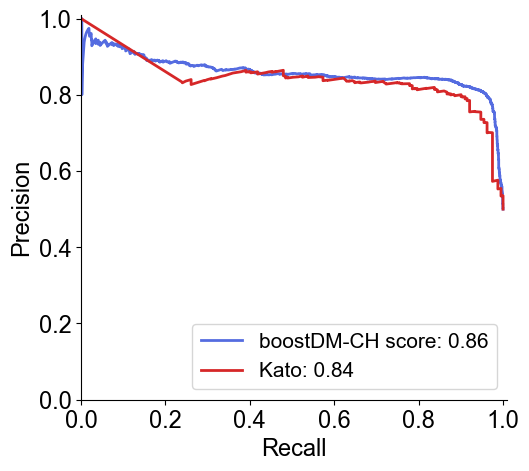

In [9]:
import matplotlib as mpl

def config_params(font_size=15):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(gene_crossval_harv_equal, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(gene_crossval_harv_equal, 'Kato', ax=ax, color='#d62728', lw=2, alpha=1)
gene_crossval_harv_equal['prob_Kato'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Kato: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

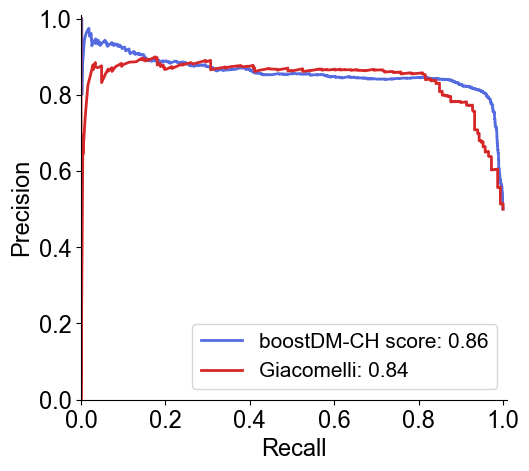

In [10]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(gene_crossval_harv_equal, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score_e, precision_e, recall_e, probs_e = plot_prc(gene_crossval_harv_equal, 'Giacomelli', ax=ax, color='#d62728', lw=2, alpha=1)
gene_crossval_harv_equal['prob_Giacomelli'] = probs_e

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Giacomelli: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [11]:
gene_crossval_harv_equal[gene_crossval_harv_equal['prob_Kato']>=0.5]['Kato'].max()

-0.0

In [12]:
gene_crossval_harv_equal['cat_Kato'] = gene_crossval_harv_equal['prob_Kato'].apply(lambda x:1 if x >=0.5 else 0)
gene_crossval_harv_equal['cat_Giacomelli'] = gene_crossval_harv_equal['prob_Giacomelli'].apply(lambda x:1 if x >=0.5 else 0)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Kato,Giacomelli,prob_Kato,prob_Giacomelli,cat_Kato,cat_Giacomelli
0,TP53,17,7674250,T,C238Y,0.0000,0,1,1,7.828125,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.816253,0,1,81,7674250T,-14.45,1.508381,0.724444,0.954180,1,1
1,TP53,17,7675185,T,V143M,0.0000,0,1,1,1.255859,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.688286,0,1,77,7675185T,-7.50,0.970286,0.788728,0.845413,1,1
2,TP53,17,7676010,A,K120M,0.0000,0,1,1,6.449219,0,1.0,0.0,0.0,1.0,1.0,1,0,0,0,T,1.0,0.957425,0,1,86,7676010A,-11.40,0.075121,0.754082,0.371621,1,0
3,TP53,17,7673796,A,C275F,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.878231,0,1,22,7673796A,-0.00,0.996383,0.844970,0.853699,1,1
4,TP53,17,7675143,A,V157F,0.0000,0,1,1,0.371094,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.624275,0,1,38,7675143A,-10.95,-0.013701,0.758268,0.321698,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,TP53,17,7673751,T,R290H,0.0000,0,0,0,-0.383057,0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.038143,49,0,5637,7673751T,-140.90,-0.373659,0.004437,0.162409,0,0
4060,TP53,17,7675995,T,T125K,0.0000,0,0,1,8.000000,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.147234,49,0,5639,7675995T,-7.55,0.331625,0.788307,0.527995,1,1
4061,TP53,17,7675070,T,R181H,0.0000,0,0,1,0.789062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.048070,49,0,5643,7675070T,-42.15,-0.331825,0.393894,0.177050,0,0
4062,TP53,17,7676584,T,P4Q,0.0000,0,0,0,1.054688,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,0.0,0.032301,49,0,5646,7676584T,-125.90,-0.537396,0.009410,0.114328,0,0


In [13]:
gene_crossval_harv_equal['cat_Giacomelli'].value_counts()

0    2059
1    2005
Name: cat_Giacomelli, dtype: int64

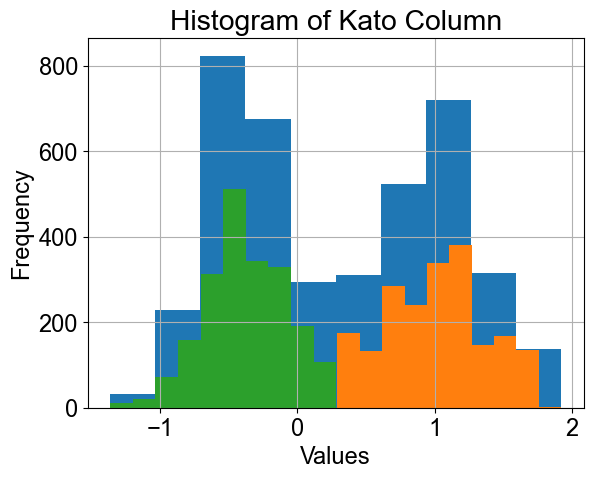

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming gene_crossval_harv_equal is your DataFrame

# Plot the histogram for the 'Kato' column
gene_crossval_harv_equal['Giacomelli'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Giacomelli']==1]['Giacomelli'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Giacomelli']==0]['Giacomelli'].hist()


# Add labels and title to the plot (optional)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Kato Column')

# Display the plot
plt.show()

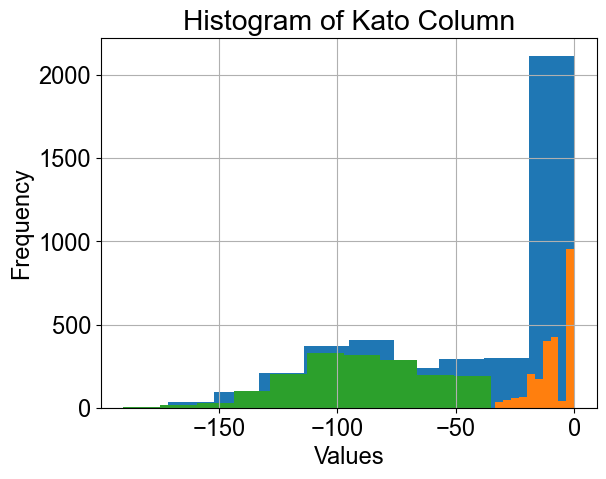

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming gene_crossval_harv_equal is your DataFrame

# Plot the histogram for the 'Kato' column
gene_crossval_harv_equal['Kato'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Kato']==1]['Kato'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Kato']==0]['Kato'].hist()


# Add labels and title to the plot (optional)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Kato Column')

# Display the plot
plt.show()

# 4. F50 score and performance

In [16]:
### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [17]:
### Define function to calculate specific statistic

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['driver']==1) & (data[method]==1)])
    tn = len(data[(data['driver']==0) & (data[method]==0)])
    fp = len(data[(data['driver']==0) & (data[method]==1)])
    fn = len(data[(data['driver']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [18]:
#Analysis

eval_boostdm = []
eval_Kato = []
eval_Giacomelli = []

#make same random
for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv_equal[gene_crossval_harv_equal['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    
    ## Calculate all statistics for each method
    for method in ['boostDM_predic', 'cat_Kato', 'cat_Giacomelli']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']: 
            # Calculate statistic
            statistics.append(quality_statistic(gene_crossval_harv_equal_i, method=method, statistic=statistic))
        if method == 'boostDM_predic': eval_boostdm.append(statistics)
        elif method == 'cat_Kato': eval_Kato.append(statistics)
        elif method == 'cat_Giacomelli': eval_Giacomelli.append(statistics)


In [19]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'Kato': pd.DataFrame(eval_Kato).mean(),
                'Giacomelli': pd.DataFrame(eval_Giacomelli).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Kato_Q1': pd.DataFrame(eval_Kato).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Kato_Q3': pd.DataFrame(eval_Kato).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Giacomelli_Q1': pd.DataFrame(eval_Giacomelli).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Giacomelli_Q3': pd.DataFrame(eval_Giacomelli).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,Kato,Giacomelli,BoostDM_Q1,BoostDM_Q3,Kato_Q1,Kato_Q3,Giacomelli_Q1,Giacomelli_Q3
0,$F_{50}$,0.840117,0.806815,0.838517,0.813536,0.863032,0.788389,0.830010,0.816234,0.865910
1,F1,0.867728,0.845391,0.834456,0.845143,0.881765,0.831516,0.864198,0.812672,0.856190
2,Accuracy,0.859554,0.831418,0.835447,0.837584,0.875000,0.816110,0.855263,0.816388,0.858307
3,Precision,0.823084,0.783199,0.841543,0.795571,0.849764,0.761905,0.807276,0.820940,0.870513
4,Recall,0.920276,0.919909,0.828893,0.899660,0.952091,0.893897,0.947013,0.804480,0.846154
5,NPV,0.911776,0.903966,0.831708,0.886995,0.940731,0.876488,0.930419,0.809086,0.848026


## Separate Kato

In [20]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)
plot_data

,Statistic,BoostDM,Kato
0,$F_{50}$,0.840117,0.806815
1,Precision,0.823084,0.783199
2,Recall,0.920276,0.919909


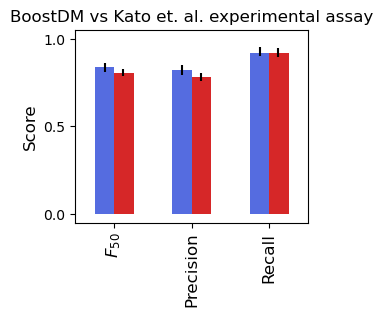

In [21]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic',\
                                                                                      figsize=(3,2.5),\
                                                                                      color=['#556CE0', '#d62728', '#304D30'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.BoostDM-row.BoostDM_Q1], [row.BoostDM_Q3-row.BoostDM]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.Kato-row.Kato_Q1], [row.Kato_Q3-row.Kato]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx+0.12,row.Kato, yerr=ci, fmt=' ', ecolor = 'k')#Add error bar BoostDM

plt.title('BoostDM vs Kato et. al. experimental assay', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

## Separate Giacomelli

In [22]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],[0,1,3]].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)
plot_data

,Statistic,BoostDM,Giacomelli
0,$F_{50}$,0.840117,0.838517
1,Precision,0.823084,0.841543
2,Recall,0.920276,0.828893


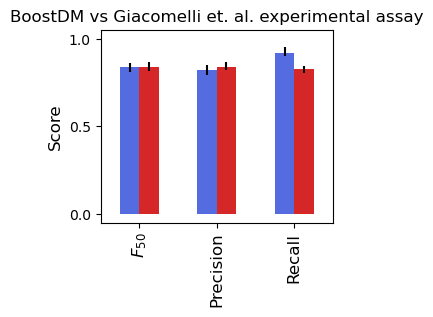

In [23]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic',\
                                                                                      figsize=(3,2.5),\
                                                                                      color=['#556CE0', '#d62728', '#304D30'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.BoostDM-row.BoostDM_Q1], [row.BoostDM_Q3-row.BoostDM]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.Giacomelli-row.Giacomelli_Q1], [row.Giacomelli_Q3-row.Giacomelli]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx+0.12,row.Giacomelli, yerr=ci, fmt=' ', ecolor = 'k')#Add error bar BoostDM

plt.title('BoostDM vs Giacomelli et. al. experimental assay', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()